In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets
from sklearn import preprocessing as sp
import pandas as pd
import seaborn as sns

In [3]:
%pip install tueplots

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: C:\Users\Haikoo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
from tueplots import bundles

In [5]:
co2_dataset = datasets.fetch_openml(data_id=41187, as_frame=True)
co2_df = co2_dataset.frame
co2_df["date"] = pd.to_datetime(co2_df[["year", "month", "day"]])
co2_df = co2_df[["date", "co2"]].set_index("date")
co2_df = co2_df.resample("M").mean().dropna(axis="index", how="any")

C:\Users\Haikoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

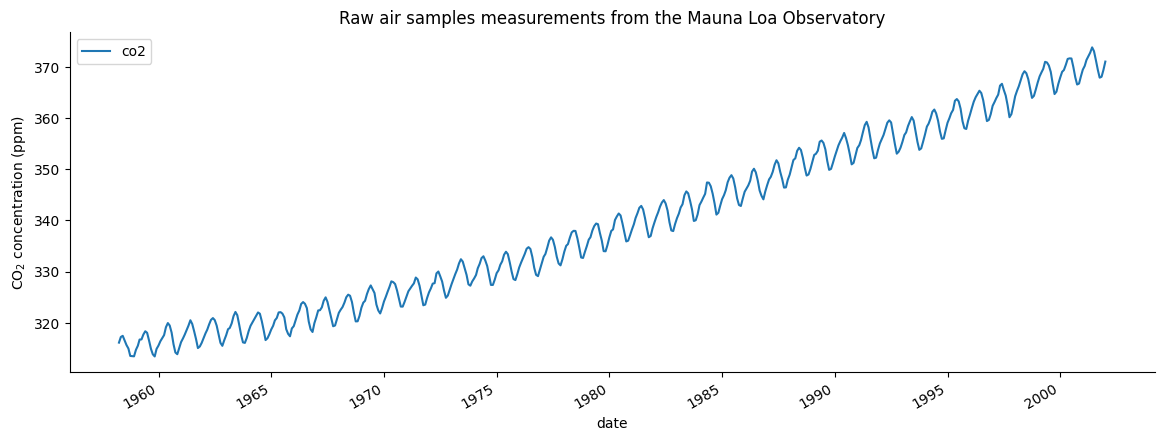

In [7]:
co2_df.plot(figsize=(14, 5))
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")
sns.despine()

In [8]:
X = (co2_df.index.year + co2_df.index.month / 12).to_numpy().reshape(-1, 1)
s = 200
n = 450
scaler = sp.StandardScaler()
scaler = scaler.fit(X[s:n])
x = scaler.transform(X[s:n])
y = np.array(co2_df["co2"][s:n])
min_max = sp.MinMaxScaler(feature_range=(0, 5))
min_max = min_max.fit(y.reshape(-1, 1))
y = min_max.transform(y.reshape(-1, 1))

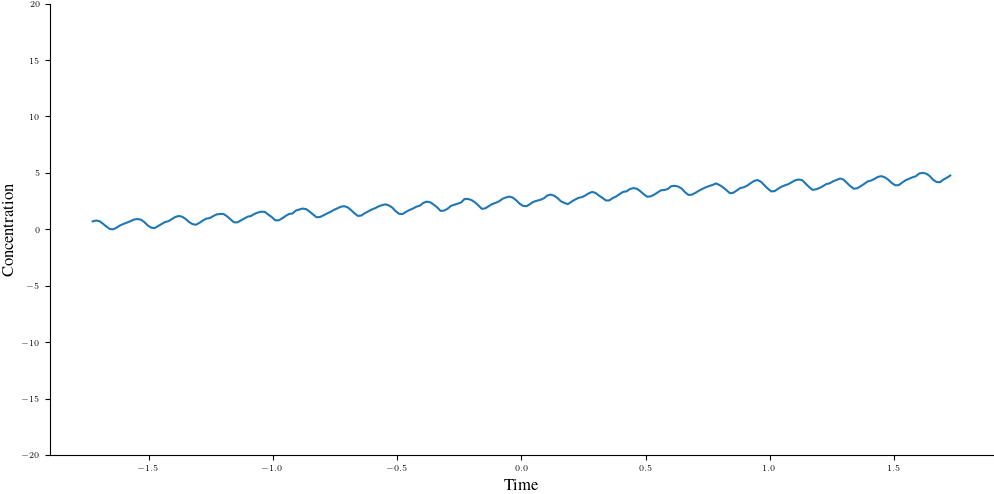

In [9]:
plt.rcParams.update(bundles.icml2022())
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.ylim(-20, 20)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
sns.despine()
plt.savefig("Raw_data.pdf", dpi=300)

In [10]:
num_extrapolate_begin = 0.2
training_fraction = 0.8
num_training_samples = int(len(x) * training_fraction)
x_train, y_train = x[:num_training_samples], y[:num_training_samples]
x_extrapolate, y_extrapolate = x[num_training_samples:], y[num_training_samples:]

In [11]:
def plot_regression_results(model, x_train, y_train, x_extrapolation, y_extrapolation):
    plt.rcParams.update(bundles.icml2022())
    x_plot = np.linspace(-2, 2, 250)
    x_plot_tensor = torch.FloatTensor(x_plot).unsqueeze(1)
    y_plot_tensor = model(x_plot_tensor).detach().numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(x_train, y_train, label="Training Data")
    plt.scatter(x_extrapolation, y_extrapolation, label="Extrapolation Data")
    plt.axvline(x=-1.72513641, color='black', linestyle='--')
    plt.axvline(x=1.0323, color='black', linestyle='--')
    plt.plot(x_plot, y_plot_tensor, color='red', label="Learned Function")
    plt.plot(x, y, color='green', label="True Function")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(-5,10)
    plt.legend()
    plt.savefig('GMLP.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class GMLPWithDropout(nn.Module):
    def __init__(self, features):
        super(GMLPWithDropout, self).__init__()
        self.features = features
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU(),
                nn.Dropout(p=0.1)
            )
            for in_features, out_features in zip([1] + features[:-1], features)
        ])
        self.output_layer = nn.Linear(features[-1], 1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

    def loss_fn(self, x, y):
        y_pred = self.forward(x)
        loss = nn.MSELoss()(y_pred, y)
        return loss

def fit(model, x_train, y_train, learning_rate=0.01, epochs=1000, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    try:
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = model.loss_fn(x_train, y_train)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if verbose and epoch % (epochs / 10) == 0:
                print(f"Loss at epoch {epoch}: {loss.item()}")
    except KeyboardInterrupt:
        print("Training interrupted.")
        return model, losses
    return model, losses

In [13]:
model = GMLPWithDropout(features=[256, 512, 256, 128])

learning_rate = 0.0005
num_epochs = 10000
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
model, losses = fit(model, x_train, y_train, learning_rate=learning_rate, epochs=num_epochs, verbose=True)

x_test = np.linspace(-1.5, 3, 200).reshape(-1, 1)
x_test = torch.FloatTensor(x_test)

def mc_dropout_inference(model, x, num_forward_passes=100):
    model.train()
    predictions = torch.stack([model(x) for _ in range(num_forward_passes)], dim=0)
    model.eval()
    return predictions

Loss at epoch 0: 5.32697868347168
Loss at epoch 1000: 0.10467313975095749
Loss at epoch 2000: 0.10171439498662949
Loss at epoch 3000: 0.09697744995355606
Loss at epoch 4000: 0.09418021887540817
Loss at epoch 5000: 0.08966659754514694
Loss at epoch 6000: 0.08008870482444763
Loss at epoch 7000: 0.07765661925077438
Loss at epoch 8000: 0.06607212871313095
Loss at epoch 9000: 0.05868467688560486


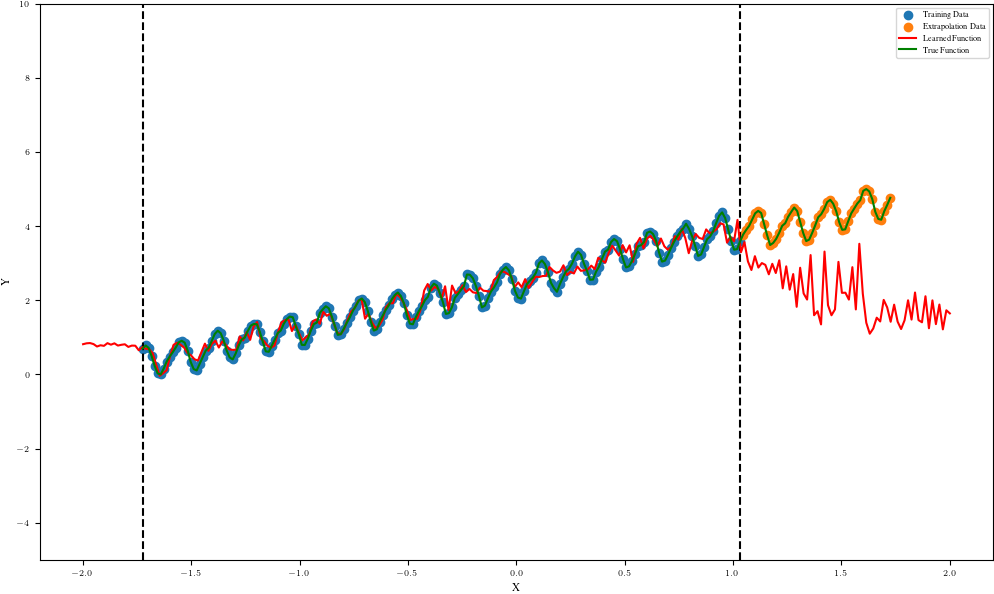

In [14]:
plot_regression_results(model, x_train, y_train, x_extrapolate, y_extrapolate)

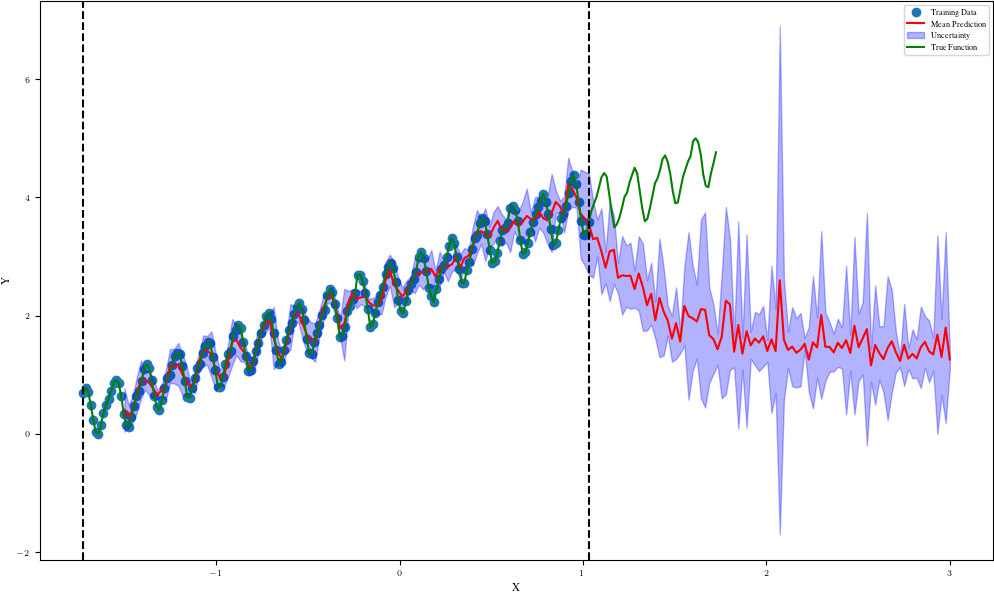

In [15]:
num_forward_passes = 5
plt.rcParams.update(bundles.icml2022())
predictions = mc_dropout_inference(model, x_test, num_forward_passes=num_forward_passes)
mean_predictions = predictions.mean(dim=0).squeeze().detach().numpy()
std_predictions = predictions.std(dim=0).squeeze().detach().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label="Training Data")
plt.plot(x_test, mean_predictions, color='red', label="Mean Prediction")
plt.fill_between(x_test.squeeze(), mean_predictions - 2 * std_predictions, mean_predictions + 2 * std_predictions, alpha=0.3, color='blue', label="Uncertainty")
plt.plot(x, y, color='green', label="True Function")
plt.axvline(x=-1.72513641, color='black', linestyle='--')
plt.axvline(x=1.0323, color='black', linestyle='--')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.savefig('MC_Dropout.pdf', dpi=300, bbox_inches='tight')
plt.show()

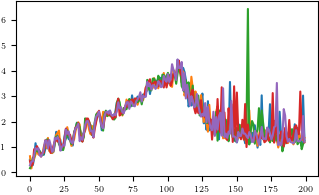

In [16]:
for i in range(5):
  plt.rcParams.update(bundles.icml2022())
  plt.plot(predictions[i].detach().numpy())
plt.savefig('Aggr.pdf', dpi=300, bbox_inches='tight')
